<a href="https://colab.research.google.com/github/MiaRosic/mtmap/blob/main/Fah_idioti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Svi potrebni paketi

In [1]:
from google.colab import drive
import os
import scipy
from scipy.io import loadmat
import scipy.sparse
import scipy.linalg as la
from scipy.sparse.linalg import svds
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from numpy.linalg import norm
import math

##Spajanje google drive-a i google colab-a



In [2]:
drive.mount('/content/drive')
os.listdir("/content/drive/MyDrive/Colab Notebooks")

Mounted at /content/drive


['Ph300.mat', 'Ph500.mat', 'Fah_idioti.ipynb']

##Učitavanje podataka

In [3]:
ulazni_podaci = loadmat("/content/drive/MyDrive/Colab Notebooks/Ph300.mat")

print (ulazni_podaci.keys()) # zadnji u rječniku je Ph300 i to koristimo za daljnje učitavanje

Ph = ulazni_podaci['Ph300']
ph=Ph.toarray()
data = pd.DataFrame(ph)

dict_keys(['__header__', '__version__', '__globals__', 'Ph300'])


## Grafički prikaz matrica

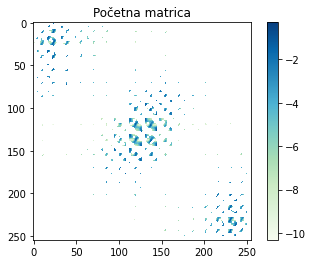

In [148]:
plt.imshow(np.log(data), cmap=plt.cm.get_cmap('GnBu'))
plt.title('Početna matrica')
plt.colorbar()
#plt.clim(-1, 1)
plt.show()

## Grafički prikaz svojstvenih vrijednosti (prvih 20 najvećih po apsolutnoj vrijednosti)

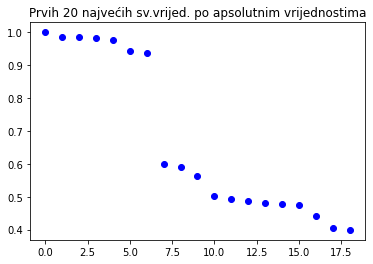

In [151]:
value, vector = la.eig(data)
svrijed = -np.sort(-abs(value))
plt.plot(svrijed[0:19], 'bo')
plt.title("Prvih 20 najvećih sv.vrijed. po apsolutnim vrijednostima")
plt.show()

## SVD algoritam

*   B - matrica
*   nB - dimenzija matrice
*   a,b - indeksi koji govore koju podmatricu gledamo
*   r - osjetljivost
*   m - broj klastera
*   n - dimenzije klastera
*   P - natrica permutacije trenutno

In [84]:
# Radim matricu
A = [[0.2018, 0.7752, 0.0003, 0.0093, 0.0048, 0.0064, 0.0022],
     [0.3950, 0.5888, 0.0027, 0.0003, 0.0043, 0.0016, 0.0073],
     [0.0093, 0.0072, 0.2911, 0.2949, 0.3938, 0.0012, 0.0025],
     [0.0064, 0.0038, 0.1947, 0.1947, 0.5580, 0.0048, 0.0049],
     [0.0003, 0.0063, 0.1034, 0.1028, 0.7713, 0.0092, 0.0067],
     [0.0082, 0.0016, 0.0067, 0.0076, 0.0027, 0.6762, 0.2970],
     [0.0089, 0.0068, 0.0030, 0.0018, 0.0065, 0.1014, 0.8715]]
A = pd.DataFrame(A)

0.5888


In [91]:
#                                                          TESTIRANJE
B=np.zeros((3,3), dtype=int)
B[2,1]=0.0008
print(B)

[[0 0 0]
 [0 0 0]
 [0 0 0]]


In [47]:
def SVD_metastabilna(B, nB, a, b, r, m, n, P):
  [U,S,V]=np.linalg.svd(B, 2) # ova funkcija računa samo prva dva sv.vektora 
  drugi_sv_vektor=U[:,1]
  indeksi_za_sortiranje=np.argsort(drugi_sv_vektor)
  sortirani_drugi_sv_vektor=np.sort(drugi_sv_vektor)
  
  dimB=len(drugi_sv_vektor)
  
  niz=np.arange(dimB) # [0, 1, ..., dimB]
  #kreiranje permutacijske matrice
  Pp = np.zeros((dimB, dimB), dtype=int)
  Pp[niz, indeksi_za_sortiranje]=1
  
  # permutiranje matrice B
  B2=np.dot(np.dot(Pp,B), np.transpose(Pp)) # Pp * B * Pp'

  # tražimo promjenu u predznaku
  ind=(np.where(np.diff(np.sign(sortirani_drugi_sv_vektor))))[0][0]

  # dodavanje permutacije u povratni P
  D=np.identity(nB)
  D[a:b, a:b]=Pp
  P=np.dot(D,P)

  # izdvajanje blokova B_prvi i B_drugi
  B_1=B2[0:ind+1, 0:ind+1]
  B_2=B2[ind+1:dimB, ind+1:dimB]

  # norma
  norma_1=(B_1.sum().sum())/ind
  norma_2=(B_2.sum().sum())/(dimB-ind)

  if ((norma_1>r) and (norma_2>r)):
    m,n,P= SVD_metastabilna(B_1, nB, a, a+ind+1, r, m, n, P)
    m,n,P= SVD_metastabilna(B_2, nB, a+ind+1, b, r, m, n, P)
    return m, n, P
  else:
    m=m+1
    n.append(dimB)
    return m, n, P

In [103]:
dimenzija = len(data)
m,n,P=SVD_metastabilna(B=data, nB=dimenzija, a=0, b=dimenzija, r=0.5, m=0, n=[], P=np.identity(dimenzija))
Q=np.dot(np.dot(P,data), np.transpose(P))
df = pd.DataFrame(Q)
print(f"m: {m}")
print(f"n: {n}")
df.head(7)

m: 7
n: [47, 20, 42, 24, 36, 46, 40]


,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
0,0.004505,0.000751,0.0,0.000751,0.000751,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002924,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.003289,0.000000,0.0,0.000000,0.000000,0.003289,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.009434,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.009434,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.0,0.010417,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
mA,nA,PA=SVD_metastabilna(B=A, nB=7, a=0, b=7, r=0.5, m=0, n=[], P=np.identity(7))
QA=np.dot(np.dot(PA,A), np.transpose(PA))
print(QA)
print(f"m: {mA}")
print(f"n: {nA}")

[[8.715e-01 1.014e-01 6.800e-03 8.900e-03 6.500e-03 1.800e-03 3.000e-03]
 [2.970e-01 6.762e-01 1.600e-03 8.200e-03 2.700e-03 7.600e-03 6.700e-03]
 [7.300e-03 1.600e-03 5.888e-01 3.950e-01 4.300e-03 3.000e-04 2.700e-03]
 [2.200e-03 6.400e-03 7.752e-01 2.018e-01 4.800e-03 9.300e-03 3.000e-04]
 [6.700e-03 9.200e-03 6.300e-03 3.000e-04 7.713e-01 1.028e-01 1.034e-01]
 [4.900e-03 4.800e-03 3.800e-03 6.400e-03 5.580e-01 1.947e-01 1.947e-01]
 [2.500e-03 1.200e-03 7.200e-03 9.300e-03 3.938e-01 2.949e-01 2.911e-01]]
m: 3
n: [2, 2, 3]


<ipython-input-47-ce8481e3c5fc>:30: RuntimeWarning: divide by zero encountered in double_scalars
  norma_1=(B_1.sum().sum())/ind


## Algoritam za matricu veza



In [138]:
def matrica_veza(Q, n, m):
  W=np.zeros((m,m), dtype=np.double)
  k=-1
  for i in range(m):
    l=-1
    for j in range(m):
      podmatrica_od_Q =Q[(k+1):(k+n[i]+1),  (l+1):(l+n[j]+1)]
      velicina_na_W_i_j = (podmatrica_od_Q.sum().sum()) / n[i]
      W[i,j] = round( velicina_na_W_i_j, 4)
      l+=n[j]
    k+=n[i]
  return W

In [139]:
WA=matrica_veza(QA,nA,mA)
print(WA)

[[0.973  0.0128 0.0142]
 [0.0088 0.9804 0.0108]
 [0.0098 0.0111 0.9682]]


In [140]:
W=matrica_veza(Q,n,m)
print(W)

[[8.027e-01 3.760e-02 2.300e-03 1.600e-03 3.610e-02 9.840e-02 2.120e-02]
 [6.650e-02 8.178e-01 1.110e-01 0.000e+00 0.000e+00 4.700e-03 0.000e+00]
 [2.000e-03 1.600e-02 8.478e-01 0.000e+00 1.600e-03 8.830e-02 4.430e-02]
 [2.080e-02 0.000e+00 0.000e+00 6.590e-01 2.315e-01 1.170e-02 7.700e-02]
 [6.710e-02 0.000e+00 1.100e-03 5.390e-02 8.141e-01 6.350e-02 4.000e-04]
 [5.280e-02 8.000e-04 4.730e-02 1.450e-02 1.208e-01 6.691e-01 9.480e-02]
 [1.080e-02 0.000e+00 3.030e-02 6.640e-02 7.600e-03 4.020e-02 8.448e-01]]


## Grafički prikaz permutirane matrice

<ipython-input-152-7e9470d432c5>:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(Q), cmap=plt.cm.get_cmap('GnBu'))


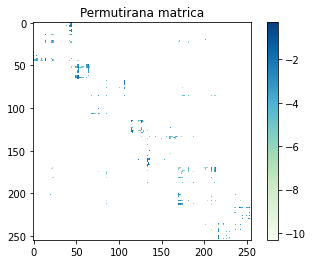

In [152]:
plt.imshow(np.log(Q), cmap=plt.cm.get_cmap('GnBu'))
plt.title('Permutirana matrica')
plt.colorbar()
#plt.clim(-1, 1)
plt.show()

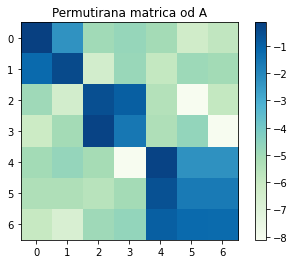

In [153]:
# Za matricu A
plt.imshow(np.log(QA), cmap=plt.cm.get_cmap('GnBu'))
plt.title('Permutirana matrica od A')
plt.colorbar()
#plt.clim(-1, 1)
plt.show()